# Processing

### Initialization

In [1]:
import numpy as np
sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((90,120)),cmap='Greys_r')

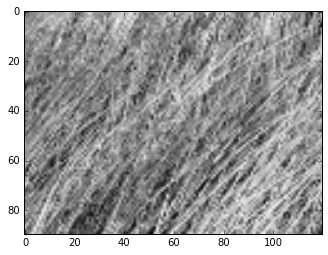

In [3]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [4]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)

sample = (sample - sample_mean)/sample_std # normalization
pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

[ 18.31028744 -16.93778624  16.20755088 -16.57174422   6.27428347
 -26.42150631  10.12611286  -5.197902    10.40013481  -9.22932565
   2.83167022  -3.90554094  10.90367232 -14.69208846   7.08630118
  -4.41553355   0.65641035  -3.42541226   2.96439156 -13.67039996]


In [5]:
print(sample)

[[-1.11651213 -1.01944808 -0.23999337 ..., -0.12147499 -1.15733176
  -1.52699203]
 [-0.28189271 -0.92650059 -0.3284865  ...,  0.78656064 -0.78029405
   1.12758945]
 [ 0.39623557 -0.8335531  -0.01876054 ...,  1.19013202  0.17680168
   3.23846147]
 ..., 
 [-2.1597864   0.14239556 -0.85944528 ...,  0.3493583  -0.72228825
   1.03164073]
 [ 1.49167355 -0.36881564 -1.25766437 ...,  0.08031071  0.98888291
   0.10413635]
 [-0.54271128  1.86192413 -0.90369185 ...,  1.02197728  0.5538394
  -0.27965856]]


## Kernels

<font color='red'>**Necessary kerns:**</font> 'lin','rbf','poly','ratquad','mlp','matern32'. Let's try to use GPy (Gaussian Process framework in python, from the Sheffield machine learning group). We'll get the following:

'lin' **class Linear**(input_dim, variances=None, ARD=False, active_dims=None, name='linear')

'rbf' **class RBF**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='rbf', useGPU=False, inv_l=False)

'poly' **class Poly**(input_dim, variance=1.0, scale=1.0, bias=1.0, order=3.0, active_dims=None, name='poly')

'ratquad' **class RatQuad**(input_dim, variance=1.0, lengthscale=None, power=2.0, ARD=False, active_dims=None, name='RatQuad')

'mlp' **class MLP**(input_dim, variance=1.0, weight_variance=1.0, bias_variance=1.0, ARD=False, active_dims=None, name='mlp')

'matern32' **class Matern32**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='Mat32')

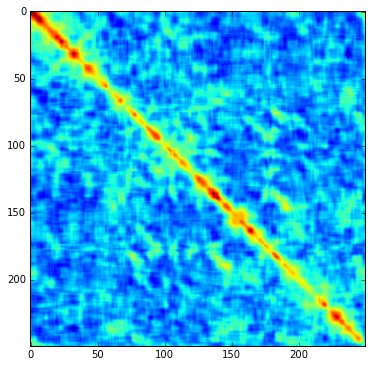

In [17]:
import GPy

fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Linear(Q).K(X,X))

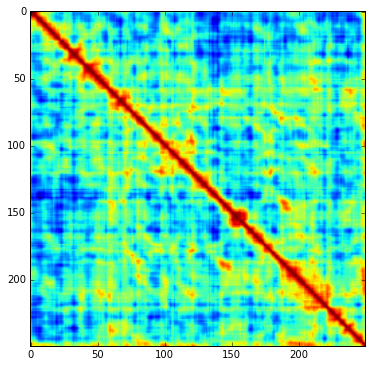

In [12]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RBF(Q,1,100).K(X,X))

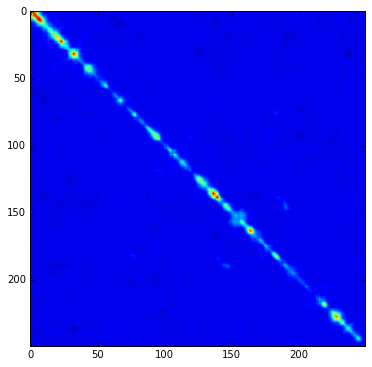

In [13]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Poly(Q,1,100).K(X,X))

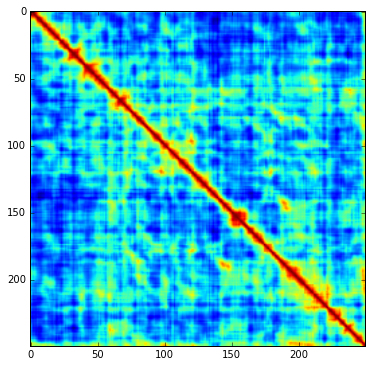

In [14]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RatQuad(Q,1,100).K(X,X))

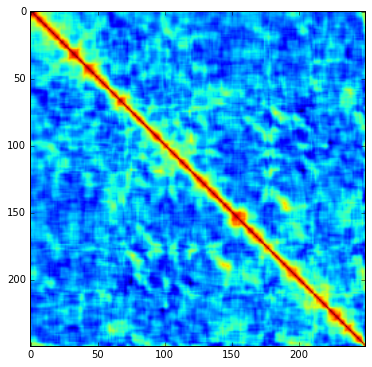

In [10]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.MLP(Q,1,100).K(X,X))

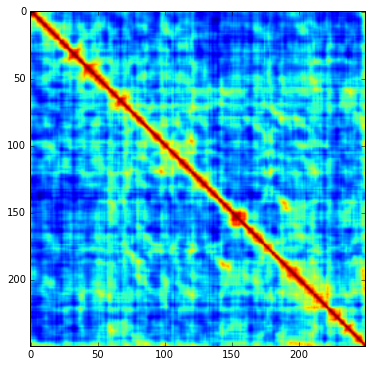

In [15]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Matern32(Q,1,100).K(X,X))

### Optimization

Kronecker Delta function:

In [23]:
def kd(x1,x2):
    
    if np.any(x1 == x2):
        return 1
    else:
        return 0

In [24]:
def kd2(N,x):
    
    result = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            result[i,j] = kd(x[i,:],x[j,:])
    
    return result

Kernel matrices:

In [25]:
def K_x(N,Q,w,x1,x2):
    
    k1 = GPy.kern.Linear(Q).K(x1[0:N-1,:],x2[0:N-1,:])
    k2 = GPy.kern.RBF(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k3 = GPy.kern.Poly(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k4 = GPy.kern.RatQuad(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k5 = GPy.kern.MLP(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k6 = GPy.kern.Matern32(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return w[0]*k1 + w[1]*k2 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd2(N-1,x1) + w[2]*k3 

In [26]:
def K_x_kern(Q):
    
    k1 = GPy.kern.Linear(Q)
    k2 = GPy.kern.RBF(Q,1,100)
    k3 = GPy.kern.Poly(Q,1,100)
    k4 = GPy.kern.RatQuad(Q,1,100)
    k5 = GPy.kern.MLP(Q,1,100)
    k6 = GPy.kern.Matern32(Q,1,100)
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return k1 + k2 + k4 + k5 + k6# + kd2(N-1,x1)# + w[2]*k3 

In [27]:
def K_y(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*((x1 - x2)**2).sum(axis=-1)) + theta[2]*kd(x1,x2)

In [28]:
def K_y_kern(Q):
    
    return GPy.kern.RBF(Q,1,100)# + theta[2]*kd(x1,x2)

Functions to optimize:

In [29]:
def f1_likelihood(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    C = 0
    Kx_inv = np.linalg.inv(Kx)
    Ky_inv = np.linalg.inv(Ky)
    part1 = 0.5*D*np.log(np.linalg.det(Ky))
    part2 = 0.5*np.trace(np.matmul(Ky_inv,np.matmul(Y,np.linalg.pinv(Y))))
    part3 = 0.5*Q*np.log(np.linalg.det(Kx))
    part4 = 0.5*np.trace(np.matmul(Kx_inv,np.matmul(X[1:N],np.transpose(X[1:N]))))
    part5 = np.sum(theta)
    part6 = np.sum(lamb)
    
    return part1 + part2 + part3 + part4 + part5 + part6 + C

In [30]:
def f2_likelihood(N,Q,Kx,X,W):
    
    alpha = 1
    Kx_inv = np.linalg.inv(Kx)
    part1 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part2 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N])))
    part3 = alpha*np.linalg.norm(W,2)

    return part1 + part2 + part3

Kx kernel matrix test:

[[ 2860.3867041   3207.80967135  3338.84669112 ...,   625.87546061
    996.01850142   958.99631007]
 [ 3207.80967135  3864.75583645  4120.05932831 ...,   627.24279285
   1032.36882359  1052.48308993]
 [ 3338.84669112  4120.05932831  4552.5797335  ...,   730.68236655
   1139.73030416  1149.25075065]
 ..., 
 [  625.87546061   627.24279285   730.68236655 ...,  2251.14839222
   1545.71996841   679.33219177]
 [  996.01850142  1032.36882359  1139.73030416 ...,  1545.71996841
   1501.66527309   955.43409017]
 [  958.99631007  1052.48308993  1149.25075065 ...,   679.33219177
    955.43409017  1035.22360561]]
5.37373421184e+126
291.807244768


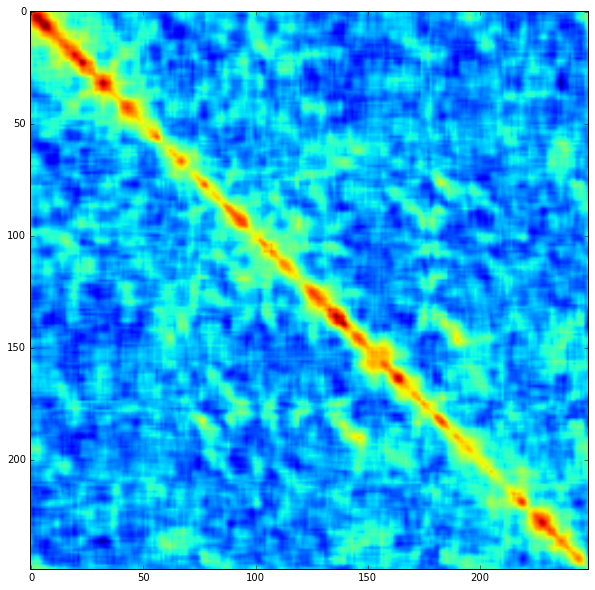

In [31]:
weights = [1, 1, 0, 1, 1, 1, 1]
Kx = K_x(N,Q,weights,X,X)

print(Kx)
print(np.linalg.det(Kx))
print(np.log(np.linalg.det(Kx)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Kx)

Ky kernel matrix test:

[[ 1.          0.98476607  0.96404196 ...,  0.88844635  0.90603787
   0.88931289]
 [ 0.98476607  1.          0.99129392 ...,  0.84802528  0.86976966
   0.85403186]
 [ 0.96404196  0.99129392  1.         ...,  0.82820632  0.84854402
   0.82861527]
 ..., 
 [ 0.88844635  0.84802528  0.82820632 ...,  1.          0.96933903
   0.93639227]
 [ 0.90603787  0.86976966  0.84854402 ...,  0.96933903  1.          0.98657653]
 [ 0.88931289  0.85403186  0.82861527 ...,  0.93639227  0.98657653  1.        ]]
-inf


 C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning:divide by zero encountered in log


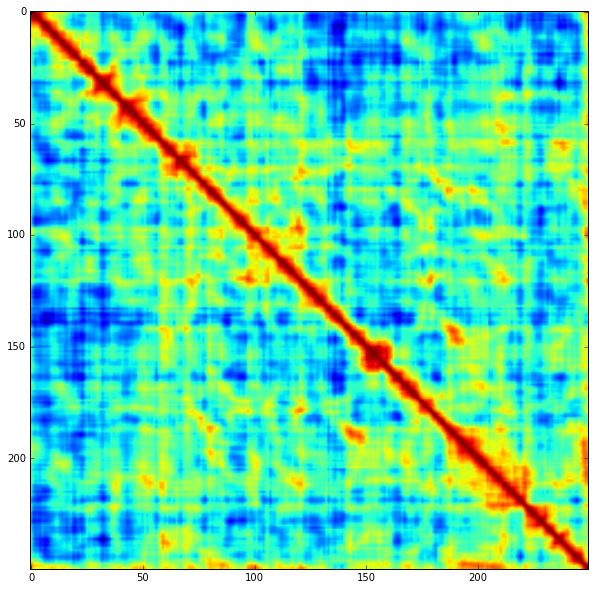

In [32]:
theta = [1, 0.0001, 0]
Ky = K_y(theta,X.reshape(1,-1,Q),X.reshape(-1,1,Q))
theta = [1, 0.0001, 0]
Ky = Ky + theta[2]*kd2(N,X)

print(Ky)
print(np.log(np.linalg.det(Ky)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Ky)

f1_likelihood test:

In [33]:
lamb = [1, 1, 1, 1, 1, 1]

print(f1_likelihood(N,D,Q,Kx,Ky,X,sample,theta,lamb))

 C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning:divide by zero encountered in log


-inf


f2_likelihood test:

In [34]:
#a = [[1,0,0],[0,1,0],[0,0,1]]
#x = [9,8,7,6]
#c = [1,2,3,4,5,6]
#print(f2_likelihood(20,4,a,x,c))

print(f2_likelihood(N,Q,Kx,X,weights))

256381.020844


Gradients of functions f1 and f2:

In [41]:
def f1_gradient(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    Kx_inv = np.linalg.inv(Kx)    
    Ky_inv = np.linalg.inv(Ky)
    
    dL_dKy = 0.5*D*np.transpose(Ky_inv)-0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))
    dL_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    dL_dx2 = 0.5*(np.matmul(Kx_inv,X[1:N])+np.matmul(np.transpose(Kx_inv),X[1:N]))
    
    dKy_dX = K_y_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
    dKx_dX = K_x_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
    dx2_dX = np.ones((Q,Q)) # OK-?
    
    dL_dX = np.matmul(dL_dKy[0:N-1,0:N-1],dKy_dX) 
    dL_dX = dL_dX + np.matmul(dL_dKx,dKx_dX)
    dL_dX = dL_dX + np.matmul(dL_dx2,dx2_dX)
    
    """dL_dTht1 = 0.5*D*np.trace(Ky_inv*dKy_dTht)
    dL_dTht2 = 0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))*dKy_dTht
    dL_dTht3 = 1/theta
    #dKy_dTht = ?
    
    dL_dTht = dL_dTht1 - dL_dTht2 + dL_dTht3
    
    dL_dLam1 = 0.5*Q*np.trace(Kx_inv*dKx_dLam)
    dL_dLam2 = 0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))*dKx_dTLam
    dL_dLam3 = 1/lamb
    #dKx_dLam = ?
    
    dL_dLam = dL_dLam1 - dL_dLam2 + dL_dLam3"""
    
    return dL_dX #[dL_dX, dL_dTheta, dL_dLam]

In [35]:
a = K_y_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
print(a)

[[-0.6597007   0.60983028 -0.58762098 ...,  0.12585949 -0.10726187
   0.50008092]
 [-0.73182266  0.68950437 -0.75627604 ...,  0.14282805 -0.10830148
   0.31610811]
 [-0.71150226  0.74385855 -0.70365953 ...,  0.20656627 -0.04805223
   0.23256937]
 ..., 
 [ 0.61473697  0.33689375 -0.5362906  ...,  0.27701641  0.01723754
  -0.08965079]
 [ 0.23441918  0.61695125 -0.45666086 ...,  0.36963146 -0.23406291
   0.13510825]
 [-0.15279427  0.58516573 -0.39666923 ...,  0.14870507 -0.25361441
  -0.03650199]]


In [36]:
print(np.size(a))

4980


In [37]:
K_x_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])

array([[-19.29175216,  17.01611636, -18.79316334, ...,   9.66817826,
        -16.08359677, -10.25729563],
       [-19.43156682,  17.19506205, -19.27445032, ...,   9.70772486,
        -16.07910543, -10.92721539],
       [-19.30377665,  17.31264395, -19.03699775, ...,   9.90585859,
        -15.87389538, -11.22349367],
       ..., 
       [-15.18722516,  16.20023567, -18.70739574, ...,  10.16591948,
        -15.63277777, -12.23296109],
       [-16.45947116,  17.21863695, -18.46910068, ...,  10.5506605 ,
        -16.53644736, -11.47227731],
       [-17.82358298,  17.15334417, -18.29531761, ...,   9.77354781,
        -16.61861643, -12.10907171]])

In [38]:
def f2_gradient2(N,Q,Kx,X,W):
    
    #params = mk_weightsConstrain(params)
    
    #[Xin, Xout] = mk_priorIO(X, segments)
    
    Kx_inv = np.linalg.inv(Kx)
    #dL_dKx = -Q/2*invKx + 0.5*invKx*(Xout*Xout')*invKx
    
    #g = zeros(length(kern.comp),1)
    
    #for i = 1:length(kern.comp)
    #    g(i) = sum(sum(dL_dKx .* Kx{i}))
    
    norm2 = 1/np.linalg.norm(W,2)
    
    #for i = 1:length(kern.comp)
    #    g(i) = g(i) + norm2 * params(i)
    
    g = g/np.linalg.norm(g)
    
    return -np.transpose(g)

In [39]:
def f2_gradient(N,Q,Kx,X,W):
    
    Kx_inv = np.linalg.inv(Kx)    
    
    dF_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    
    dF_dW = np.sum(dF_dKx) * np.sum(Kx) + W/np.linalg.norm(W,2)
    
    return dF_dW

f1_gradient test:

In [42]:
gradf1 = f1_gradient(N,D,Q,Kx,Ky,X,sample,theta,lamb)
print(gradf1)
print(np.size(gradf1))

[[ -9.99720237e+08   1.56995589e+09  -1.92364867e+09 ...,   9.50452415e+08
    8.10042882e+08   3.56636658e+08]
 [  3.75554961e+09  -2.78233257e+09   2.19728315e+09 ...,  -1.28693606e+09
    2.83959088e+08  -5.64072116e+08]
 [ -3.23540093e+09   2.48335359e+09  -1.75878256e+09 ...,   3.57125470e+08
    5.55273119e+08  -6.14967146e+08]
 ..., 
 [ -3.83212073e+08  -1.66239270e+09   2.08710102e+09 ...,   1.85021725e+08
    9.87866045e+08  -6.99388732e+08]
 [  9.80856973e+07   4.01384988e+09  -6.06833554e+09 ...,   1.45573768e+09
   -2.33658947e+09  -8.11943995e+08]
 [  3.63451631e+09  -6.51950483e+09   1.06407849e+10 ...,  -4.02018876e+09
    5.13352481e+09   2.41174492e+09]]
4980


f2_gradient test:

In [43]:
W = [1,1,0,1,1,1,1]
gradf2 = f2_gradient(N,Q,Kx,X,W)
print(gradf2)
print(np.size(gradf2))

[ 4164528.20452648  4164528.20452648  4164527.79627819  4164528.20452648
  4164528.20452648  4164528.20452648  4164528.20452648]
7


In [44]:
w = np.transpose(W)
check = GPy.models.GradientChecker(lambda a: f2_likelihood(N,Q,Kx,X,a),lambda b: f2_gradient(N,Q,Kx,X,b),x0 = w.copy())
check.checkgrad(verbose=1)

           Name            |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------
 GradientChecker.X[[0]]    |   0.000000    |4164527.796287 |-4164528.204526|   -0.408239   |     3e-12     
 GradientChecker.X[[1]]    |   0.000000    |4164527.796287 |-4164528.204526|   -0.408239   |     3e-12     
 GradientChecker.X[[2]]    |   -0.000000   |4164527.796278 |-4164527.796278|   0.000000    |     0e+00     
 GradientChecker.X[[3]]    |   0.000000    |4164527.796287 |-4164528.204526|   -0.408239   |     3e-12     
 GradientChecker.X[[4]]    |   0.000000    |4164527.796287 |-4164528.204526|   -0.408239   |     3e-12     
 GradientChecker.X[[5]]    |   0.000000    |4164527.796287 |-4164528.204526|   -0.408239   |     3e-12     
 GradientChecker.X[[6]]    |   0.000000    |4164527.796287 |-4164528.204526|   -0.408239   |     3e-12     


False

In [ ]:
# TODO: 

#[params, options, flog] = scg('mk_likelihood', params, options, 'mk_gradient', Y, segments, kern)

In [6]:
m.optimize(messages=True, optimizer = 'SCG', max_iters=10)